In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
np.random.seed(42)
random.seed(42)
RANDOM_SEED = 42
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('../Data/all_in_one.csv')
data.Datetime = pd.to_datetime(data.Datetime)
data.head()

,Datetime,temp,desc,icon,baro,wind,wd,hum,rain,fog,...,curfew,etat_barre_ce,q_ce,k_ce,etat_barre_lc,q_lc,k_lc,etat_barre_pv,q_pv,k_pv
0,2014-01-01 00:00:00,7.0,Low clouds.,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-01 01:00:00,6.0,Low clouds.,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,...,0.0,3.0,4.0,0.00000,3.0,205.0,2.25945,3.0,486.0,6.17889
2,2014-01-01 02:00:00,6.0,Low clouds.,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,...,0.0,3.0,21.0,0.10445,3.0,283.0,3.25111,3.0,571.0,6.66222
3,2014-01-01 03:00:00,6.0,Low clouds.,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,...,0.0,3.0,417.0,6.12667,3.0,309.0,3.36000,3.0,532.0,5.56611
4,2014-01-01 04:00:00,6.0,Low clouds.,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,...,0.0,3.0,1089.0,14.39890,3.0,277.0,3.01445,3.0,458.0,4.63444


In [3]:
data = data[(data.Datetime <= '2020-11-30')]
data.head()

,Datetime,temp,desc,icon,baro,wind,wd,hum,rain,fog,...,curfew,etat_barre_ce,q_ce,k_ce,etat_barre_lc,q_lc,k_lc,etat_barre_pv,q_pv,k_pv
0,2014-01-01 00:00:00,7.0,Low clouds.,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-01 01:00:00,6.0,Low clouds.,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,...,0.0,3.0,4.0,0.00000,3.0,205.0,2.25945,3.0,486.0,6.17889
2,2014-01-01 02:00:00,6.0,Low clouds.,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,...,0.0,3.0,21.0,0.10445,3.0,283.0,3.25111,3.0,571.0,6.66222
3,2014-01-01 03:00:00,6.0,Low clouds.,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,...,0.0,3.0,417.0,6.12667,3.0,309.0,3.36000,3.0,532.0,5.56611
4,2014-01-01 04:00:00,6.0,Low clouds.,17.0,1011.0,15.0,220.0,92.0,0.0,0.0,...,0.0,3.0,1089.0,14.39890,3.0,277.0,3.01445,3.0,458.0,4.63444


In [4]:
features = ['temp',
 'icon',
 'baro',
 'wind',
 'wd',
 'hum',
 'rain',
 'fog',
 'thunder',
 'snow',
 'Férié',
 'Vacances',
 'confinement_1',
 'confinement_2',
 'confinement_3',
 'curfew']

# Utils

In [5]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

In [6]:
def create_features(df, label=None, bare=None):
    """
    Creates time series features from datetime index
    """

    df['hour'] = df['Datetime'].dt.hour
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['quarter'] = df['Datetime'].dt.quarter
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    df['dayofmonth'] = df['Datetime'].dt.day
    df['weekofyear'] = df['Datetime'].dt.weekofyear
    all_features = ['hour','dayofweek','quarter','month','year', 'dayofyear','dayofmonth','weekofyear'] + features
    if bare is not None:
        all_features += [bare]
    X = df[all_features]
    if label:
        y = df[label]
        return X, y
    return X

# Xgboost on Champs Elysées

## Choose how many data we need

In [8]:
historical_dates = ['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', 
                   '2018-09-01', '2019-01-01', '2019-06-01', '2019-10-01', '2019-12-01']
split_dates = ['2020-10-21', '2020-10-26', '2020-10-31', '2020-11-05', '2020-11-10', '2020-11-15',
            '2020-11-20', '2020-11-25']
limit = ['2020-10-26', '2020-10-31', '2020-11-05', '2020-11-10', '2020-11-15', '2020-11-20', '2020-11-25', '2020-11-30']

In [10]:
## Q Champs elysées
score_rmse = {k: [] for k in historical_dates}
for date in historical_dates:
    our_data = data[data.Datetime >= date]
    for i, split_date in enumerate(split_dates):
        max_date = limit[i]
        data_train = our_data.loc[our_data.Datetime < split_date].copy()
        data_train = data_train[data_train.q_ce.notnull()]
        data_test = our_data.loc[(our_data.Datetime >= split_date) & (our_data.Datetime < max_date)].copy()
        data_test = data_test[data_test.q_ce.notnull()]
        X_train, y_train = create_features(data_train, label='q_ce')
        X_test, y_test = create_features(data_test, label='q_ce')
        reg = xgb.XGBRegressor(n_estimators=1000)
        reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=60, verbose=False)
        score_rmse[date].append(rmse(y_test.values, reg.predict(X_test)))

<ipython-input-6-20d5a858f4c2>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Datetime'].dt.weekofyear


In [12]:
score_rmse_q = {k: sum(v)/len(v) for k,v in score_rmse.items()}

In [13]:
score_rmse_q

{'2014-01-01': 194.24291312976428,
 '2015-01-01': 184.9835581457528,
 '2016-01-01': 193.25900117460873,
 '2017-01-01': 206.12325669633015,
 '2018-01-01': 197.8110752406897,
 '2018-09-01': 183.93377068382517,
 '2019-01-01': 187.4710482060804,
 '2019-06-01': 185.21794205527485,
 '2019-10-01': 178.5249247949651,
 '2019-12-01': 165.87494063100215}

In [14]:
## Q Champs elysées
score_rmse_k = {k: [] for k in historical_dates}
for date in historical_dates:
    our_data = data[data.Datetime >= date]
    for i, split_date in enumerate(split_dates):
        max_date = limit[i]
        data_train = our_data.loc[our_data.Datetime < split_date].copy()
        data_train = data_train[data_train.k_ce.notnull()]
        data_test = our_data.loc[(our_data.Datetime >= split_date) & (our_data.Datetime < max_date)].copy()
        data_test = data_test[data_test.k_ce.notnull()]
        X_train, y_train = create_features(data_train, label='k_ce')
        X_test, y_test = create_features(data_test, label='k_ce')
        reg = xgb.XGBRegressor(n_estimators=1000)
        reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=60, verbose=False)
        score_rmse_k[date].append(rmse(y_test.values, reg.predict(X_test)))

<ipython-input-6-20d5a858f4c2>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Datetime'].dt.weekofyear


In [15]:
score_rmse_k = {k: sum(v)/len(v) for k,v in score_rmse_k.items()}

In [16]:
score_rmse_k

{'2014-01-01': 4.204796602893334,
 '2015-01-01': 4.090977463104782,
 '2016-01-01': 4.1646714111791745,
 '2017-01-01': 4.154030817231476,
 '2018-01-01': 4.18696893865218,
 '2018-09-01': 4.229964766120116,
 '2019-01-01': 4.3678804796319906,
 '2019-06-01': 3.9239256879698905,
 '2019-10-01': 3.7014836441698344,
 '2019-12-01': 3.845394717240406}

We will take only data from 2019-11-01

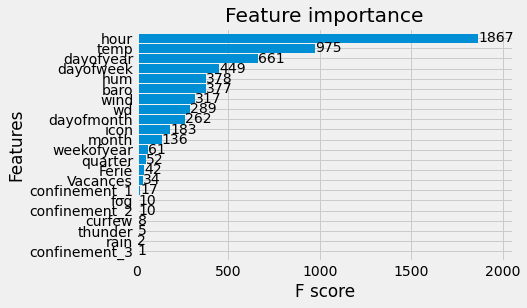

In [22]:
_ = plot_importance(reg, height=0.9)

## COVID INFLUENCE

In [33]:
data = data[data.Datetime>='2019-01-01']

In [34]:
data[(data.confinement_1==1) | (data.confinement_2==1) | (data.confinement_3==1)].q_ce.mean()

473.8671111111111

In [35]:
data[(data.confinement_1==0) & (data.confinement_2==0) & (data.confinement_3==0)].q_ce.mean()

788.6646402398401

In [36]:
data[(data.confinement_1==1) | (data.confinement_2==1) | (data.confinement_3==1)].k_ce.mean()

7.371574862222222

In [37]:
data[(data.confinement_1==0) & (data.confinement_2==0) & (data.confinement_3==0)].k_ce.mean()

13.955284708563417

We can see that during the covid we have less trafic